In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords
from ema_workbench.util.utilities import load_results

In [2]:
# load results
experiment, result = load_results('uncertainty_rerun.tar.gz')
results = pd.read_csv('03_MORO_results.csv')
inputs = results.iloc[:,:32]
outcomes = results.iloc[:,32:]

In [3]:
outcomes = outcomes.rename(columns={"Expected_Damage":"Expected Damage", "Dike_Costs":"Cost for dike heigthening","RfR_Costs":"Cost for Room for the River", "Evacuation_Costs":"Cost of Evacuation", "Number_of_Deaths":"Expected number of deaths", "wl":"Minimum Waterlevel"})

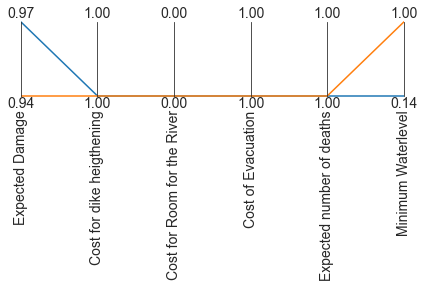

In [4]:
limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)
plt.show()

In [6]:
results_pol1 = pd.DataFrame()
results_pol2 = pd.DataFrame()
results_pol1['Expected Annual Damage'] = result['Expected Annual Damage'][:1000]
results_pol2['Expected Annual Damage'] = result['Expected Annual Damage'][1000:]
results_pol1['Dike Investment Costs'] = result['Dike Investment Costs'][:1000]
results_pol2['Dike Investment Costs'] = result['Dike Investment Costs'][1000:]
results_pol1['RfR Investment Costs'] = result['RfR Investment Costs'][:1000]
results_pol2['RfR Investment Costs'] = result['RfR Investment Costs'][1000:]
results_pol1['Evacuation Costs'] = result['Evacuation Costs'][:1000]
results_pol2['Evacuation Costs'] = result['Evacuation Costs'][1000:]
results_pol1['Expected Number of Deaths'] = result['Expected Number of Deaths'][:1000]
results_pol2['Expected Number of Deaths'] = result['Expected Number of Deaths'][1000:]
results_pol1['Minimum water level full network'] = result['Minimum water level full network'][:1000]
results_pol2['Minimum water level full network'] = result['Minimum water level full network'][1000:]

objectives = ['Expected Annual Damage', 'Dike Investment Costs','RfR Investment Costs','Evacuation Costs',
              'Expected Number of Deaths','Minimum water level full network']

In [38]:
# Robustness metrics
def hurwitz(data,column_names,alpha=0):
    '''weighs off the best and worst payoffs'''
    results = {}
    
    for column_name in column_names:
        Max_value = data[column_name].max()
        Min_value = data[column_name].min()

        #calculate hurwitz coefficient as described in Arrow (1972)
        hurwitz_coef = alpha * Max_value + (1-alpha) * Min_value
        results[column_name] = hurwitz_coef
    
    
    return results

def mean_variance(data,column_names):
    '''for maximization this is defined as the mean divided by the standard deviation (Kwakkel et al, 2019)'''
    results = {}
    
    for column_name in column_names:
        mean_value = data[column_name].mean()
        std_value = data[column_name].std()
        if abs(std_value) < 0.001:
            mv_coef = 0
        else:
            mv_coef = mean_value/std_value
        results[column_name] = mv_coef
    
    return results

def quartile_skewedness(data,column_names):
    '''returns the quartile that contains the most observations'''
    results = {}
    for column_name in column_names:
        #place all results in four equally spaced bins
        data['MyQuantileBins'] =  pd.cut(data[column_name], 4)
        values = data['MyQuantileBins'].value_counts()

        #determine which quartile (bin) is overrepresented (contains the most values)
        for i in range(3):
            if max(values) == values[i]:
                #save the quartile and the percentage of values it contains in a dictionary
                results[column_name] = (i+1,(values[i]/values.sum()))    
    return results, values

In [22]:
pol1dictHur = hurwitz(results_pol1,objectives)
pol1dictHur

{'Expected Annual Damage': 0.0,
 'Dike Investment Costs': 746831863.6008538,
 'RfR Investment Costs': 1635000000.0,
 'Evacuation Costs': 0.0,
 'Expected Number of Deaths': 0.0,
 'Minimum water level full network': 4.418353787064368}

In [23]:
pol2dictHur = hurwitz(results_pol2,objectives)
pol2dictHur

{'Expected Annual Damage': 0.0,
 'Dike Investment Costs': 822714507.6447107,
 'RfR Investment Costs': 953000000.0,
 'Evacuation Costs': 0.0,
 'Expected Number of Deaths': 0.0,
 'Minimum water level full network': 4.538353787064368}

In [25]:
pol1dictMv = mean_variance(results_pol1,objectives)
pol1dictMv

{'Expected Annual Damage': 0.06149643929027182,
 'Dike Investment Costs': 0,
 'RfR Investment Costs': 0,
 'Evacuation Costs': 0.07505424864173904,
 'Expected Number of Deaths': 0,
 'Minimum water level full network': 27.26451664778911}

In [26]:
pol2dictMv = mean_variance(results_pol2,objectives)
pol2dictMv

{'Expected Annual Damage': 0.13324424513365463,
 'Dike Investment Costs': 0,
 'RfR Investment Costs': 0,
 'Evacuation Costs': 0.12799874011050041,
 'Expected Number of Deaths': 0.13062213239645204,
 'Minimum water level full network': 27.99570142583141}

In [20]:
pol1dictQs = quartile_skewedness(results_pol1,objectives)
pol1dictQs

{'Expected Annual Damage': 0.06149643929027182,
 'Dike Investment Costs': 0,
 'RfR Investment Costs': 0,
 'Evacuation Costs': 0.07505424864173904,
 'Expected Number of Deaths': 0,
 'Minimum water level full network': 27.26451664778911}

In [39]:
pol2dictQs, pol2dictQsval = quartile_skewedness(results_pol2,objectives)
pol2dictQs.values()

dict_values([(1, 0.991), (1, 1.0), (1, 1.0), (1, 0.99), (1, 0.99), (1, 0.894)])

In [40]:
pol2dictQsval

(4.537, 4.783]    894
(4.783, 5.028]     52
(5.028, 5.273]     38
(5.273, 5.518]     16
Name: MyQuantileBins, dtype: int64